Exercice 1 : Séries temporelles L’objectif de cet exercice est de prédire les  cotations  d’une action en  utilisant  des  réseaux
récurrents.

1.  Télécharger un dataset contenant l’historique des cotations  d’une action de votre
choix (votre entreprise en alternance, facebook, google, CAC40, etc.). Vous trouverez
ce qu’il faut ici : https://www.nasdaq.com. Il est conseillé de prendre la plus grande
période possible pour avoir le dataset le plus grand possible.

2. Charger  le  fichier  CSV  en  python  et  explorer  le  dataset.  Proposer  une  ou  plusieurs
représentations graphiques permettant de visualiser les données.

In [1]:
%pip install mplcursors -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras import layers as L

# Load data
NASDAQ100 = pd.read_csv("HistoricalData.csv")

# Convert the Date column
NASDAQ100["Date"] = pd.to_datetime(NASDAQ100["Date"])
NASDAQ100 = NASDAQ100.sort_values("Date").reset_index(drop=True)
NASDAQ100["Close/Last"] = pd.to_numeric(NASDAQ100["Close/Last"])

# Plot interactive line chart
fig = px.line(
    NASDAQ100,
    x="Date",
    y="Close/Last",
    title="NASDAQ 100 Historical Prices",
    labels={"Date": "Date", "Close/Last": "Close/Last"},
    hover_data={"Date": "|%Y-%m-%d", "Close/Last": ":.2f"},
)

# Optional: style improvements
fig.update_traces(line=dict(width=2, color="#1f77b4"), name="NASDAQ-100")
fig.update_layout(hovermode="x unified", template="plotly_white", legend_title_text="")

# Show interactive figure
fig.show()

3. Sélectionner  la  ou  les  colonnes  permettant  la  prédiction  les  cotations  de l’action
sélectionnée.

In [3]:
NASDAQ100 = NASDAQ100[["Date", "Close/Last"]]

print(NASDAQ100.head())

        Date  Close/Last
0 2015-11-09     4655.52
1 2015-11-10     4641.73
2 2015-11-11     4636.94
3 2015-11-12     4588.93
4 2015-11-13     4502.14


4. Préparer un dataset d’entrainement et de test pour l’apprentissage. En particulier, le
dataset doit être constitué de séquences de valeurs (en entrée) permettant de prédire
la (ou les) valeur(s) suivante(s) de cette séquence (target).

In [ ]:
def prepare_data(data, window=60):
    X = []
    y = []
    for i in range(window, len(data)):
        X.append(data[i - window : i])
        y.append(data[i])
    return np.array(X).reshape(-1, window, 1), np.array(y)


# -----------------------------
# 1. Extract raw values
# -----------------------------
values = NASDAQ100["Close/Last"].values.reshape(-1, 1)

# -----------------------------
# 2. Train / test split (time-based)
# -----------------------------
n_test = int(len(values) * 0.2)
train_values = values[:-n_test]
test_values = values[-n_test:]

# -----------------------------
# 3. Fit scaler ONLY on training data
# -----------------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# -----------------------------
# 4. Build sliding windows
# -----------------------------
X_train_NASDAQ, y_train_NASDAQ = prepare_data(train_scaled, window=60)
X_test_NASDAQ, y_test_NASDAQ = prepare_data(test_scaled, window=60)

print("Train:", X_train_NASDAQ.shape, y_train_NASDAQ.shape)
print("Test:", X_test_NASDAQ.shape, y_test_NASDAQ.shape)

input_shape = (X_train_NASDAQ.shape[1], X_train_NASDAQ.shape[2])
print("Input shape:", input_shape)

EPOCHS = 20
BATCH_SIZE = 32

Train: (1953, 60, 1) (1953, 1)
Test: (443, 60, 1) (443, 1)
Input shape: (60, 1)


5.  Proposer et comparer quelques architectures neuronales à partir de couches LSTM et
GRU.  Sélectionner celle permettant d’obtenir les meilleurs résultats. Dans cette
question, la prédiction doit être faite à très court terme. Vous pouvez aussi utiliser des
couches convolutionnel 1D pour évaluer l’impact de la mémoire long terme.

In [ ]:
from typing import Literal, Optional, Sequence, Union
from tensorflow import keras
from tensorflow.keras import layers as L

TaskType = Literal["regression", "binary", "multiclass"]
RNNType = Literal["lstm", "gru", "bilstm"]
OutputMode = Literal["many_to_one", "many_to_many"]


def build_sequence_model(
    # Core
    input_shape: tuple,
    task: TaskType,
    rnn_type: RNNType = "lstm",
    output_mode: OutputMode = "many_to_one",
    # Architecture
    units: Union[int, Sequence[int]] = 50,  # int -> single layer; list -> stacked
    dense_units: Optional[int] = None,  # optional Dense before output
    # Output space (universal)
    output_dim: Optional[
        int
    ] = None,  # required for multiclass; optional for regression (defaults)
    use_sparse_labels: bool = False,  # for multiclass: y int labels vs one-hot
    # Regression-specific
    horizon: int = 1,  # regression output dimension if not using output_dim
    # Dropout (separated)
    inter_layer_dropout: float = 0.0,  # Dropout BETWEEN layers/blocks
    rnn_dropout: float = 0.0,  # dropout INSIDE recurrent layer
    recurrent_dropout: float = 0.0,  # recurrent dropout INSIDE recurrent layer
    # Optional Conv1D front-end (for sequence feature extraction)
    conv1d_filters: Optional[int] = None,
    conv1d_kernel_size: int = 3,
    conv1d_padding: str = "causal",
    pool_size: int = 2,
    # Optional Embedding path (for integer-ID sequences)
    use_embedding: bool = False,
    input_vocab_size: Optional[int] = None,  # required if use_embedding=True
    embed_dim: int = 64,
    mask_zero: bool = False,
    # Compile
    optimizer: Union[str, keras.optimizers.Optimizer] = "adam",
    metrics_override: Optional[Sequence[Union[str, keras.metrics.Metric]]] = None,
):
    """
    Universal sequence model builder:
    - Works for numeric time series, categorical/discrete sequences, NLP tokens, symbolic sequences, etc.
    - Supports many_to_one and many_to_many outputs.
    - Supports regression, binary classification, multiclass classification.
    - Optional Embedding for integer-ID inputs.
    - Optional Conv1D front-end.
    """

    # -------------------------
    # Validate output_mode
    # -------------------------
    if output_mode not in ("many_to_one", "many_to_many"):
        raise ValueError("output_mode must be 'many_to_one' or 'many_to_many'.")

    # -------------------------
    # Normalize units list
    # -------------------------
    if isinstance(units, int):
        units_list = [units]
    else:
        units_list = list(units)
        if not units_list:
            raise ValueError("units must be an int or a non-empty list/tuple of ints.")

    # -------------------------
    # Determine output config
    # -------------------------
    if task == "multiclass":
        if output_dim is None or output_dim < 2:
            raise ValueError(
                "For task='multiclass', provide output_dim >= 2 (number of classes)."
            )
        out_units = output_dim
        out_activation = "softmax"
        loss = (
            "sparse_categorical_crossentropy"
            if use_sparse_labels
            else "categorical_crossentropy"
        )
        default_metrics = ["accuracy"]

    elif task == "binary":
        out_units = 1
        out_activation = "sigmoid"
        loss = "binary_crossentropy"
        default_metrics = ["accuracy"]

    elif task == "regression":
        if output_dim is None:
            if horizon < 1:
                raise ValueError("For regression, horizon must be >= 1.")
            out_units = horizon
        else:
            if output_dim < 1:
                raise ValueError("For regression, output_dim must be >= 1 if provided.")
            out_units = output_dim
        out_activation = None
        loss = "mse"
        default_metrics = ["mae"]

    else:
        raise ValueError("task must be one of: 'regression', 'binary', 'multiclass'.")

    metrics = (
        list(metrics_override) if metrics_override is not None else default_metrics
    )

    # -------------------------
    # Build layers (Sequential)
    # -------------------------
    layers = [L.Input(shape=input_shape)]

    # Embedding path: input should be integer IDs. Typical input_shape: (seq_len,)
    if use_embedding:
        if input_vocab_size is None or input_vocab_size < 2:
            raise ValueError("If use_embedding=True, provide input_vocab_size >= 2.")
        layers.append(
            L.Embedding(
                input_dim=input_vocab_size, output_dim=embed_dim, mask_zero=mask_zero
            )
        )

    # Masking + Conv1D generally incompatible (mask propagation breaks)
    if use_embedding and mask_zero and conv1d_filters is not None:
        raise ValueError(
            "mask_zero=True with Embedding is not compatible with Conv1D/Pooling front-end here."
        )

    # Optional Conv1D front-end
    if conv1d_filters is not None:
        layers += [
            L.Conv1D(
                filters=conv1d_filters,
                kernel_size=conv1d_kernel_size,
                activation="relu",
                padding=conv1d_padding,
            ),
            L.MaxPooling1D(pool_size=pool_size),
        ]
        if inter_layer_dropout > 0:
            layers.append(L.Dropout(inter_layer_dropout))

    # RNN factory
    def make_rnn_layer(u: int, return_sequences: bool):
        if rnn_type == "lstm":
            return L.LSTM(
                u,
                return_sequences=return_sequences,
                dropout=rnn_dropout,
                recurrent_dropout=recurrent_dropout,
            )
        if rnn_type == "gru":
            return L.GRU(
                u,
                return_sequences=return_sequences,
                dropout=rnn_dropout,
                recurrent_dropout=recurrent_dropout,
            )
        if rnn_type == "bilstm":
            base = L.LSTM(
                u,
                return_sequences=return_sequences,
                dropout=rnn_dropout,
                recurrent_dropout=recurrent_dropout,
            )
            return L.Bidirectional(base)
        raise ValueError("rnn_type must be one of: 'lstm', 'gru', 'bilstm'.")

    # Last layer must return sequences only for many_to_many
    need_seq_out = output_mode == "many_to_many"

    for i, u in enumerate(units_list):
        is_last = i == len(units_list) - 1
        return_seq = (not is_last) or (is_last and need_seq_out)
        layers.append(make_rnn_layer(u, return_seq))

        # Dropout between stacked recurrent layers
        if (not is_last) and inter_layer_dropout > 0:
            layers.append(L.Dropout(inter_layer_dropout))

    # Optional Dense block before output
    if dense_units is not None:
        if output_mode == "many_to_many":
            layers.append(L.TimeDistributed(L.Dense(dense_units, activation="relu")))
            if inter_layer_dropout > 0:
                layers.append(L.Dropout(inter_layer_dropout))
        else:
            layers.append(L.Dense(dense_units, activation="relu"))
            if inter_layer_dropout > 0:
                layers.append(L.Dropout(inter_layer_dropout))

    # Output head
    if output_mode == "many_to_many":
        layers.append(L.TimeDistributed(L.Dense(out_units, activation=out_activation)))
    else:
        layers.append(L.Dense(out_units, activation=out_activation))

    model = keras.Sequential(layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
models = {
    "LSTM": build_sequence_model(
        input_shape=input_shape,
        task="regression",
        rnn_type="lstm",
        output_mode="many_to_one",
        units=64,  # single recurrent layer
        dense_units=32,  # optional dense before output
        inter_layer_dropout=0.2,  # between blocks
        rnn_dropout=0.0,
        recurrent_dropout=0.0,
        optimizer="adam",
    ),
    "Stacked LSTM": build_sequence_model(
        input_shape=(60, 1),
        task="regression",
        rnn_type="lstm",
        output_mode="many_to_one",
        units=[32, 32, 32, 32],  # stacked
        inter_layer_dropout=0.2,  # dropout between recurrent layers
        dense_units=None,  # optional
    ),
    "GRU": build_sequence_model(
        input_shape=(60, 1),
        task="regression",
        rnn_type="gru",
        units=[64, 64],
        inter_layer_dropout=0.2,
    ),
    "Conv1D+LSTM": build_sequence_model(
        input_shape=(60, 1),
        task="regression",
        rnn_type="lstm",
        units=64,
        conv1d_filters=32,
        conv1d_kernel_size=3,
        conv1d_padding="causal",
        pool_size=2,
        inter_layer_dropout=0.2,
    ),
}

histories = {}
results = {}

for name, model in models.items():
    print(f"\n===== Training {name} =====")
    history = model.fit(
        X_train_NASDAQ,
        y_train_NASDAQ,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
    )
    histories[name] = history

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test_NASDAQ, y_test_NASDAQ, verbose=0)
    results[name] = {"test_mse": test_loss, "test_mae": test_mae}
    print(f"{name} - Test MSE: {test_loss:.6f}, Test MAE: {test_mae:.6f}")



===== Training LSTM =====
LSTM - Test MSE: 0.002441, Test MAE: 0.041988

===== Training Stacked LSTM =====
Stacked LSTM - Test MSE: 0.040427, Test MAE: 0.187893

===== Training GRU =====
GRU - Test MSE: 0.000977, Test MAE: 0.024153

===== Training Conv1D+LSTM =====
Conv1D+LSTM - Test MSE: 0.018725, Test MAE: 0.120832


In [7]:
results_df = pd.DataFrame(results).T
print("\n===== Comparison of models on test set (scaled values) =====")
print(results_df)


===== Comparison of models on test set (scaled values) =====
              test_mse  test_mae
LSTM          0.002441  0.041988
Stacked LSTM  0.040427  0.187893
GRU           0.000977  0.024153
Conv1D+LSTM   0.018725  0.120832


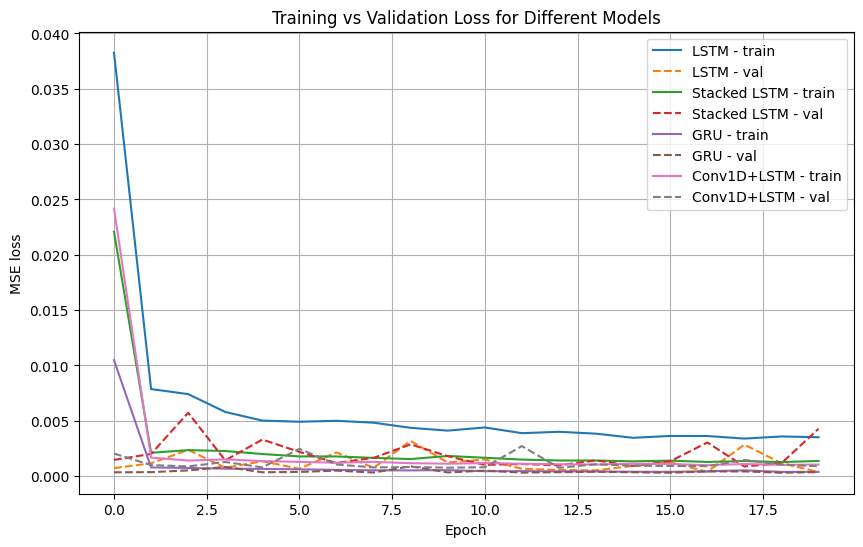

In [8]:
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history.history["loss"], label=f"{name} - train")
    plt.plot(history.history["val_loss"], linestyle="--", label=f"{name} - val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training vs Validation Loss for Different Models")
plt.legend()
plt.grid(True)
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


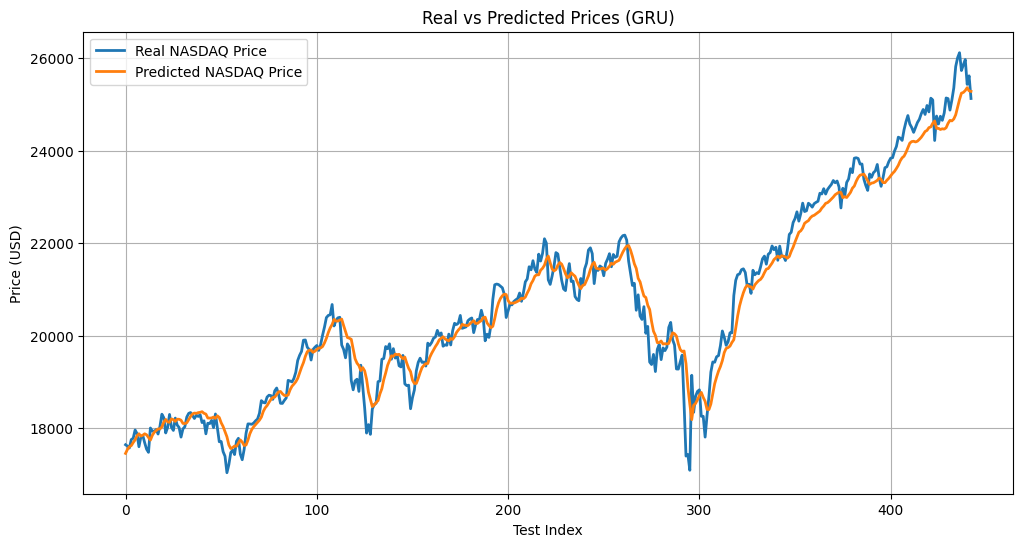

In [9]:
# Predict using best model
best_model_name = min(results, key=lambda k: results[k]["test_mse"])
best_model = models[best_model_name]
y_pred_test = best_model.predict(X_test_NASDAQ)

# Reshape for inverse_transform
y_test_NASDAQ_reshaped = y_test_NASDAQ.reshape(-1, 1)

# Inverse transform to original scale
y_test_real = scaler.inverse_transform(y_test_NASDAQ_reshaped)
y_pred_real = scaler.inverse_transform(y_pred_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label="Real NASDAQ Price", linewidth=2)
plt.plot(y_pred_real, label="Predicted NASDAQ Price", linewidth=2)
plt.title(f"Real vs Predicted Prices ({best_model_name})")
plt.xlabel("Test Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


6. Explorer la capacité de prédiction de ce système sur des plus long terme (prédiction à
plusieurs jours).

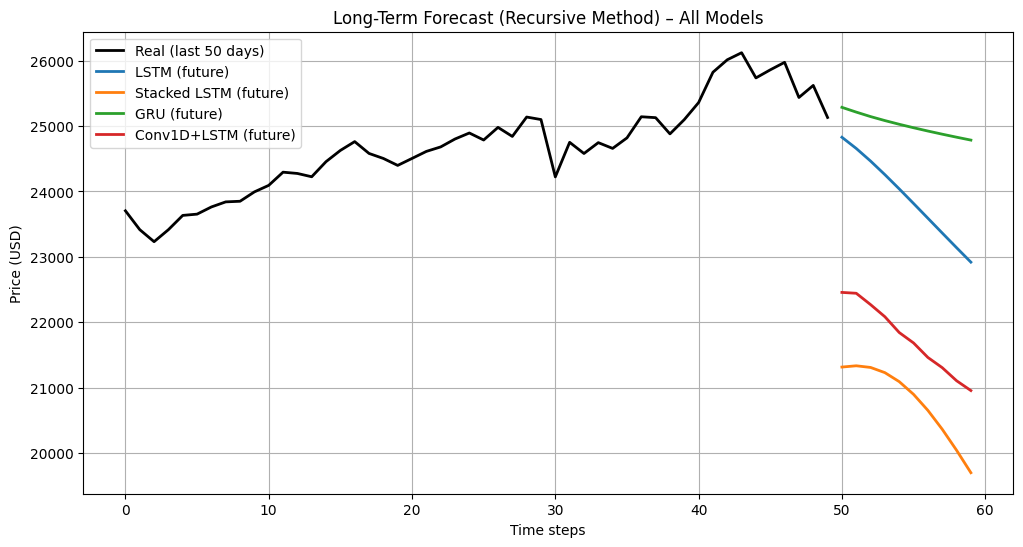

In [ ]:
future_steps = 10  # predict next 10 days
window_size = X_test_NASDAQ.shape[1]  # normally 60
last_window = X_test_NASDAQ[-1]  # starting window

future_predictions_all = {}  # real-scale predictions for each model

# ---- Run long-term forecast for each model ----
for name, model in models.items():
    current_input = last_window.copy()
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(current_input.reshape(1, window_size, 1), verbose=0)
        future_predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred).reshape(window_size, 1)

    # Convert predictions to original price scale
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_real = scaler.inverse_transform(future_predictions)

    future_predictions_all[name] = future_real


# ---- Combined plot ----
plt.figure(figsize=(12, 6))

# Plot last 50 real values
real_last_50 = scaler.inverse_transform(y_test_NASDAQ[-50:].reshape(-1, 1))
plt.plot(real_last_50, label="Real (last 50 days)", linewidth=2, color="black")

# Plot all model predictions
for name, future_real in future_predictions_all.items():
    plt.plot(
        np.arange(50, 50 + future_steps),
        future_real,
        label=f"{name} (future)",
        linewidth=2,
    )

plt.title("Long-Term Forecast (Recursive Method) – All Models")
plt.xlabel("Time steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Exercice 2 : Génération de texte car2car L’objectif  de  cet  exercice  est  de  créer  un  programme  permettant  de  générer
automatiquement  la fin d’une phrase. Pour cela,  nous allons l’entrainer à prédire caractère
par  caractère  (car2car)  un  livre fourni.  Dans  cet  exercice,  nous  utiliserons  une  architecture
basée sur les LSTM. Le réseau sera entrainé sur un livre, Alice au pays de merveille, que vous
pouvez télécharger sur l’espace de cours.

1. Télécharger le fichier alice.txt depuis l’espace de cours. Charger ce fichier en python
et afficher son contenu.

In [11]:
ALICE_PATH = "alice.txt"
with open(ALICE_PATH, "r") as file:
    alice_text = file.read()
print(alice_text[:100])

The Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll

This eBook is fo


2. Depuis la chaîne de caractères précédemment chargée, générer la liste de caractères
uniques présents dans le livre. Écrire une méthode permettant de transformer chaque
caratère en entier et inversement (chaque entier en caractère). Ceci est nécessaire car
les réseaux de neurones ne travaillent pas sur des caractères mais sur des nombres !


In [12]:
chars = sorted(list(set(alice_text)))
print("Unique characters:", len(chars))
vocab_size = len(chars)

char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

Unique characters: 90


3. Préparer  un  dataset  contenant  des  séquences  de  50  caractères  (paramétrable)  de
longueur en entrée et le caractère suivant cette séquence en target.

In [ ]:
def prepare_car2car(text, window=50):
    encoded = np.array([char_to_int[c] for c in text], dtype=np.int32)

    X = np.zeros((len(encoded) - window, window), dtype=np.int32)
    y = np.zeros((len(encoded) - window,), dtype=np.int32)

    for i in range(len(encoded) - window):
        X[i] = encoded[i : i + window]
        y[i] = encoded[i + window]

    return X, y


X, y = prepare_car2car(alice_text)

n_test = int(len(X) * 0.2)
X_train_alice, X_test_alice = X[:-n_test], X[-n_test:]
y_train_alice, y_test_alice = y[:-n_test], y[-n_test:]

print("X_train:", X_train_alice.shape, X_train_alice.dtype)
print("y_train:", y_train_alice.shape, y_train_alice.dtype)
print("X_test :", X_test_alice.shape, X_test_alice.dtype)
print("y_test :", y_test_alice.shape, y_test_alice.dtype)

# Sanity checks for label range (prevents NaN)
print("vocab_size:", vocab_size)
print("y_train min/max:", int(y_train_alice.min()), int(y_train_alice.max()))
print("y_test  min/max:", int(y_test_alice.min()), int(y_test_alice.max()))

X_train: (131173, 50) int32
y_train: (131173,) int32
X_test : (32793, 50) int32
y_test : (32793,) int32
vocab_size: 90
y_train min/max: 0 88
y_test  min/max: 0 88


4. Transformer le dataset en séquence « one hot encodées »

In [ ]:
EPOCHS = 15
BATCH = 128


def to_onehot(x, y):
    x = tf.one_hot(x, depth=vocab_size)  # (batch, seq_len, vocab_size)
    y = tf.one_hot(y, depth=vocab_size)  # (batch, vocab_size)
    return x, y


train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_alice, y_train_alice))
    .shuffle(50000)
    .batch(BATCH)
    .map(to_onehot, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_alice, y_test_alice))
    .batch(BATCH)
    .map(to_onehot, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

for xb, yb in train_ds.take(1):
    print("xb:", xb.shape, xb.dtype)  # (BATCH, 50, 90)
    print("yb:", yb.shape, yb.dtype)  # (BATCH, 90)
    print(
        "yb row-sum min/max:",
        tf.reduce_min(tf.reduce_sum(yb, axis=-1)).numpy(),
        tf.reduce_max(tf.reduce_sum(yb, axis=-1)).numpy(),
    )

xb: (128, 50, 90) <dtype: 'float32'>
yb: (128, 90) <dtype: 'float32'>
yb row-sum min/max: 1.0 1.0


5. Proposer et tester différentes architecture LSTM entrainées sur le dataset
précédemment généré.

In [ ]:
input_shape = (X_train_alice.shape[1], vocab_size)

models = {
    "LSTM_1x128": build_sequence_model(
        input_shape=input_shape,
        task="multiclass",
        rnn_type="lstm",
        units=128,
        output_dim=vocab_size,
        use_sparse_labels=False,  # y is one-hot
        output_mode="many_to_one",
    ),
    "Stacked_LSTM_2x128_dropout": build_sequence_model(
        input_shape=input_shape,
        task="multiclass",
        rnn_type="lstm",
        units=[128, 128],
        output_dim=vocab_size,
        use_sparse_labels=False,
        inter_layer_dropout=0.2,  # dropout BETWEEN layers
        rnn_dropout=0.0,
        recurrent_dropout=0.0,
        output_mode="many_to_one",
    ),
    "GRU_1x128": build_sequence_model(
        input_shape=input_shape,
        task="multiclass",
        rnn_type="gru",
        units=128,
        output_dim=vocab_size,
        use_sparse_labels=False,
        output_mode="many_to_one",
    ),
    "Conv1D_64k5_LSTM_128": build_sequence_model(
        input_shape=input_shape,
        task="multiclass",
        rnn_type="lstm",
        units=128,
        output_dim=vocab_size,
        use_sparse_labels=False,
        conv1d_filters=64,
        conv1d_kernel_size=5,
        pool_size=2,
        inter_layer_dropout=0.2,
        output_mode="many_to_one",
    ),
}

histories = {}
results = {}

for name, model in models.items():
    print(f"\n===== Training {name} =====")
    h = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
    )
    histories[name] = h

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    results[name] = {
        "best_val_loss": float(np.min(h.history["val_loss"])),
        "best_val_acc": float(np.max(h.history["val_accuracy"])),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "params": int(model.count_params()),
    }
    print(f"{name} - Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}")

results_df = pd.DataFrame(results).T.sort_values(by=["test_loss", "best_val_loss"])

display(results_df)


===== Training LSTM_1x128 =====
LSTM_1x128 - Test Loss: 2.248721, Test Accuracy: 0.420059

===== Training Stacked_LSTM_2x128_dropout =====
Stacked_LSTM_2x128_dropout - Test Loss: 2.206853, Test Accuracy: 0.430214

===== Training GRU_1x128 =====
GRU_1x128 - Test Loss: 2.264878, Test Accuracy: 0.437441

===== Training Conv1D_64k5_LSTM_128 =====
Conv1D_64k5_LSTM_128 - Test Loss: 2.270800, Test Accuracy: 0.415516


,best_val_loss,best_val_acc,test_loss,test_acc,params
Stacked_LSTM_2x128_dropout,2.206853,0.430214,2.206853,0.430214,255322.0
LSTM_1x128,2.235761,0.421035,2.248721,0.420059,123738.0
GRU_1x128,2.197238,0.441527,2.264878,0.437441,96090.0
Conv1D_64k5_LSTM_128,2.270800,0.416003,2.270800,0.415516,139290.0


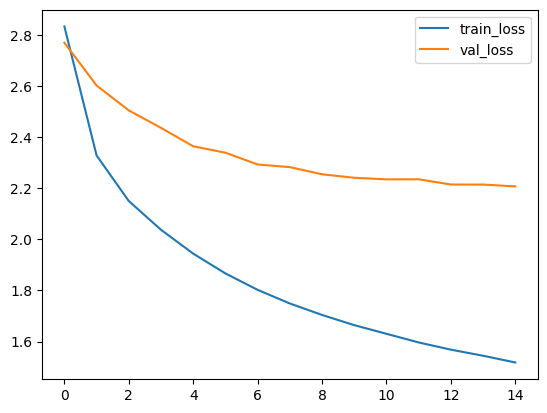

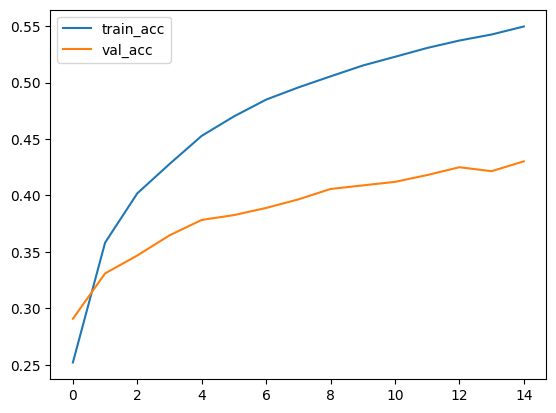

In [16]:
best_name = results_df.index[0]
best_model = models[best_name]

h = histories[best_name].history
plt.plot(h["loss"], label="train_loss")
plt.plot(h["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(h["accuracy"], label="train_acc")
plt.plot(h["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

6. Tester la meilleure architecture sur une chaine de caractères qu’il n’a jamais vu, soit
du  dataset  de  test,  soit  que  vous  proposerez  vous.  Attention  à  bien  utiliser  votre
convertisseur caractère/entier pour pouvoir chiffrer et déchiffrer les informations du
réseau.

In [ ]:
# --------- Sampling utility ----------
def sample_top_k(probs, k=20, temperature=1.0):
    probs = np.asarray(probs).astype(np.float64)

    # temperature
    if temperature is not None and temperature > 0:
        probs = np.log(probs + 1e-12) / temperature
        probs = np.exp(probs)

    # keep only top-k
    idx = np.argpartition(probs, -k)[-k:]
    top_probs = probs[idx]
    top_probs = top_probs / np.sum(top_probs)

    return int(np.random.choice(idx, p=top_probs))


# --------- Prepare seed: from raw text to IDs ----------
def text_to_ids(text, char_to_int):
    return [char_to_int.get(c, 0) for c in text]


# --------- Generation (model expects one-hot input) ----------
def generate_text_onehot_model(
    model,
    seed_text,
    char_to_int,
    int_to_char,
    vocab_size,
    window=50,
    length=400,
    temperature=1.0,
):
    # Ensure seed length == window
    if len(seed_text) < window:
        seed_text = (" " * (window - len(seed_text))) + seed_text
    else:
        seed_text = seed_text[-window:]

    generated = seed_text

    for _ in range(length):
        # Get last window chars -> IDs
        x_ids = text_to_ids(generated[-window:], char_to_int)  # len=window

        # IDs -> one-hot (1, window, vocab_size)
        x_oh = tf.one_hot(
            [x_ids], depth=vocab_size, dtype=tf.float32
        )  # shape (1, window, vocab_size)

        # Predict next-char distribution
        probs = model.predict(x_oh, verbose=0)[0]  # shape (vocab_size,)

        # Sample next id
        next_id = sample_top_k(probs, k=20, temperature=0.8)

        # Append char
        generated += int_to_char[next_id]

    return generated


# --------- Choose a seed from the book ----------
window = 50
start = 3000  # you can change this
seed = alice_text[start : start + window]

print("Seed:\n", seed)

print("\n--- Generated (temperature=0.8) ---\n")
print(
    generate_text_onehot_model(
        best_model,
        seed,
        char_to_int,
        int_to_char,
        vocab_size=vocab_size,
        window=window,
        length=400,
        temperature=0.8,
    )
)

print("\n--- Generated (temperature=1.2) ---\n")
print(
    generate_text_onehot_model(
        best_model,
        seed,
        char_to_int,
        int_to_char,
        vocab_size=vocab_size,
        window=window,
        length=400,
        temperature=1.2,
    )
)


Seed:
  had not a moment to think
about stopping herself 

--- Generated (temperature=0.8) ---

 had not a moment to think
about stopping herself no, awwan about to and of the grick us much the foused sitten, that the fich, and she ade think on the Gryphon daresily.

“Not was growing ut the Mock Turtle know,” Alice well it looked the
Duchess forded of the Dodmought in them; and the Caterpillar for, and all. “What iver that you you pood that you then,” said Alice with the King.

“You was a had!” the March Hare.

“What it’s pime talk to it ab

--- Generated (temperature=1.2) ---

 had not a moment to think
about stopping herself about a or the was too mad replim. As they could not a soa. Alice to say, “The rather was some wating to see
could be and the wrill to little houre on a gone to be looking a toor her was genered, and noticed in the Gryphon,
and she could her and the toppe is with of how she add said dight at the gottle a sitched that the Gryphon’
 And was to see on. “I’m be and h